### NMR shieldings
* Moleküleingabe vom xyz- file, idealerweise aus DFT Optimierung
* Berechnung anisotroper Verschiebung
* Ergebnisse weichen deutlich vom Abaluf ohne GPU Unterstützung ab
* einiges ist im GPU Modul noch experimentell, daher nicht weiter verwenden bevor intensiv getestet

In [8]:
#####################################
#
# Computing NMR shielding constants
#
######################################


xyzin="xyz/nitromethan.xyz"   # funktioniert
logfile="test_g.log"

import pyscf
import gpu4pyscf
from gpu4pyscf import dft
from gpu4pyscf.properties.shielding import eval_shielding
mol = pyscf.M(atom=xyzin, basis='6-31g*', output=logfile)

mf = dft.RKS(mol)
mf.xc = 'b3lyp'

mf = mol.RKS().to_gpu().run()
tensor = eval_shielding(mf)


overwrite output file: test_g.log


In [9]:
abschirmung = tensor[0].get()+tensor[1].get()
#abschirmung

In [10]:
#################################################################################################
#
# Constanten für Verschiebungsberchnung
#
# CSHESHIRE Repository (Tantillo)
#
# Table 1a and 1b
#
# delta = (intercept -sigma)/ - slope
#
# Das Vorzeichen von slope wird gleich in die Definition der Konstanten eingepflegt
#
# TMS shielding aus eigener Berechnung delta = sigma - TMS
#
##################################################################################################

intercept1a = 187.4743
slope1a = 0.9269
intercept1b = 188.4418
slope1b = 0.9449
intercept1c = 188.01
slope1c = 0.9378
tmsshield = 190.2218

h_intercept1a = 32.2884
h_slope1a = 0.9957
h_intercept1b = 32.2109
h_slope1b = 1.0157
h_intercept1c = 32.2448
h_slope1c = 1.004
h_tmsshield = 32.1893

shift = [0] *mol.natm
shift1a = [0] *mol.natm
shift1b= [0] *mol.natm
shift1c= [0] *mol.natm
shifttms= [0] *mol.natm


data = []
for i in range(mol.natm):
    shift[i]= (abschirmung[i,0,0] + abschirmung[i,1,1] + abschirmung[i,2,2])/3
    #print(f"Atom {mol._atom[i][0]} {i} hat eine totale Abschirmung von {shift[i]} .")

    if  mol._atom[i][0] =='C':
        shift1a[i] = (intercept1a-shift[i])/slope1a
        shift1b[i] = (intercept1b-shift[i])/slope1b
        shift1c[i] = (intercept1c-shift[i])/slope1c
        shifttms[i] = tmsshield - shift[i]
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale Abschirmung': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})

    if  mol._atom[i][0] =='H':
        shift1a[i] = (h_intercept1a-shift[i])/h_slope1a
        shift1b[i] = (h_intercept1b-shift[i])/h_slope1b
        shift1c[i] = (h_intercept1c-shift[i])/h_slope1c
        shifttms[i] = h_tmsshield - shift[i]
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale Abschirmung': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})
 

In [11]:
import pandas as pd
from IPython.display import display, HTML
# Erstelle ein DataFrame
df = pd.DataFrame(data)

# Setze die Spaltenüberschriften
df.columns = ['Atom', 'Index', 'Totale Abschirmung', 'table1a', 'table1b', 'table1c', 'TMS']

# Zeige die Tabelle an
display(HTML(df.to_html(index=False)))

Atom,Index,Totale Abschirmung,table1a,table1b,table1c,TMS
H,1,27.293154,5.016818,4.841731,4.931918,4.896146
C,2,131.118339,60.800476,60.666167,60.665026,59.103461
H,6,27.795236,4.512568,4.347410,4.431837,4.394064
H,7,27.795236,4.512568,4.347410,4.431837,4.394064


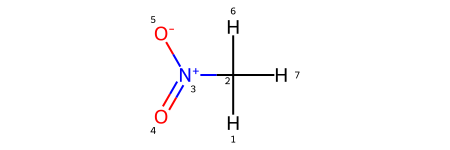

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole


def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()+1))
    return mol

raw_mol = Chem.MolFromXYZFile(xyzin)
mol2 = Chem.Mol(raw_mol)
Chem.rdDetermineBonds.DetermineBonds(mol2)
# mol2
AllChem.Compute2DCoords(mol2)
show_atom_number(mol2, 'atomNote')